In [1]:
import os
import copy
import glob
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.notebook import tqdm

import h5py

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.nn.modules.activation import ReLU, Sigmoid
from torch.nn import Conv2d, modules
from torch.nn import Sequential
import torch.nn.init as init

import torch.backends.cudnn as cudnn

In [2]:
# utils functions
def img_read(fPath, Gray=True):
    '''
    read the image given path "fPath"
    '''
    if Gray:
        return cv2.imread(fPath, -1)
    else:
        hr_img = cv2.imread(fPath)
        hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB)
    return hr_img



def getLR(hr_img, scale):
    '''
    bibubic downsmaple to get the corresponding low-resolution image by scaling factor "scale"
    '''
    h_orig = 0 
    w_orig = 0

    if len(hr_img.shape) == 2:
        h_orig, w_orig = hr_img.shape
    elif len(hr_img.shape) == 3:
        h_orig, w_orig, _ = hr_img.shape
    else:
        print("Image format is not correct")
        
    h, w = int(h_orig/scale), int(w_orig/scale)
    lr_img = cv2.resize(hr_img, (w, h), interpolation=cv2.INTER_NEAREST) # 30*30
    lr_img = cv2.resize(lr_img, (w_orig, h_orig), interpolation=cv2.INTER_CUBIC) # 120*120
    return lr_img



def get_sequence_LR(img_sequence):
    for i in range(len(img_sequence)):
        img_sequence[i] = getLR(img_sequence[i])
    return img_sequence



def computePSNR(img1, img2):
    '''
    compute PSNR(Peak Signal to Noise Ratio) to calculate accuracy
    img1 and img2 have range [0, 1], and both are gray level images
    '''
    if not img1.shape == img2.shape:
        print("Input images must have the same dimensions.")
    mse = torch.mean((img1-img2)**2)
    if mse == 0: # img1 and img2 are same images
        return float('inf')
    return 10.0 * torch.log10(1.0/mse)

In [3]:
# SRCNN

class SRCNN(nn.Module):
    def __init__(self, num_channels=3):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_channels, 
                               out_channels=64, 
                               kernel_size=9, 
                               padding=9 // 2)
        self.conv2 = nn.Conv2d(in_channels=64, 
                               out_channels=32, 
                               kernel_size=1, 
                               padding=5 // 2)
        self.conv3 = nn.Conv2d(in_channels=32, 
                               out_channels=num_channels, 
                               kernel_size=5, 
                               padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x
    
    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight)

In [4]:
# VSRNet

class VSRNet(nn.Module):
    def __init__(self, upscale_factor, srcnn, num_channels=1, device='cuda'):
        super(VSRNet, self).__init__()

        self.conv1_f0 = nn.Conv2d(1,  64, (9, 9), (1, 1), (4, 4))
        self.conv1_f1 = nn.Conv2d(1,  64, (9, 9), (1, 1), (4, 4))
        self.conv1_f2 = nn.Conv2d(1,  64, (9, 9), (1, 1), (4, 4))
        
#        Symetry Constraint || self.conv1_f3 = self.conv1_f1 || self.conv1_f4 = self.conv1_f0
#        self.conv1_f3 = nn.Conv2d(1,  64, (9, 9), (1, 1), (0, 0))
#        self.conv1_f4 = nn.Conv2d(1,  64, (9, 9), (1, 1), (0, 0))
        
        self.conv2 = nn.Conv2d(320, 32, (5, 5), (1, 1), (2, 2))
        self.conv3 = nn.Conv2d(32, 1,  (5, 5), (1, 1), (2, 2))
        
        self.srcnn = srcnn
        self.upscale_factor = upscale_factor
        self.num_channels = num_channels
        self.device = device
        
        self._initialize_weights()

    def forward(self, x):
        
        h10 = x[:,[0],:,:]
        h11 = x[:,[1],:,:]
        h12 = x[:,[2],:,:]
        h13 = x[:,[3],:,:]
        h14 = x[:,[4],:,:]        
        
#        h10 = h10.view(h10.size[0], 1, h10.size[1], h10.size[2])
#        h11 = h11.view(h11.size[0], 1, h10.size[1], h10.size[2])
#        h12 = h12.view(h12.size[0], 1, h10.size[1], h10.size[2])
#        h13 = h13.view(h13.size[0], 1, h10.size[1], h10.size[2])
#        h14 = h14.view(h14.size[0], 1, h10.size[1], h10.size[2])
        
        h10 = self.conv1_f0(h10)
        h11 = self.conv1_f1(h11)
        h12 = self.conv1_f2(h12)
        h13 = self.conv1_f1(h13)
        h14 = self.conv1_f0(h14) 
     
        x = nn.functional.relu(torch.cat((h10, h11, h12, h13, h14), 1))
        
        x = nn.functional.relu(self.conv2(x))
        x = (self.conv3(x))
        return x
    
    def _initialize_weights(self):
        
        #srcnn_model = torch.load(self.srcnn_model, map_location=lambda storage, loc: storage) # forcing to load to CPU
        
        srcnn_model = SRCNN(num_channels=self.num_channels).to(self.device)

        state_dict = srcnn_model.state_dict()
        for n, p in torch.load(self.srcnn, map_location=lambda storage, loc: storage).items():
            if n in state_dict.keys():
                state_dict[n].copy_(p)
            else:
                raise KeyError(n)
        
        self.conv1_f0.weight.data = (srcnn_model.conv1.weight.data).clone()
        self.conv1_f1.weight.data = (srcnn_model.conv1.weight.data).clone()
        self.conv1_f2.weight.data = (srcnn_model.conv1.weight.data).clone()
        
        self.conv1_f0.bias.data = (srcnn_model.conv1.bias.data).clone()
        self.conv1_f1.bias.data = (srcnn_model.conv1.bias.data).clone()
        self.conv1_f2.bias.data = (srcnn_model.conv1.bias.data).clone()
        
        self.conv2.weight.data = torch.cat((srcnn_model.conv2.weight.data, 
                                            srcnn_model.conv2.weight.data, 
                                            srcnn_model.conv2.weight.data, 
                                            srcnn_model.conv2.weight.data, 
                                            srcnn_model.conv2.weight.data), 1).clone()/5.0
        self.conv2.bias.data = (srcnn_model.conv2.bias.data).clone()
        

        self.conv3.weight.data = (srcnn_model.conv3.weight.data).clone()
        self.conv3.bias.data = (srcnn_model.conv3.bias.data).clone()
        



In [9]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:

class SRData(Dataset):
    def __init__(self, imgFolder, sequenceSize, patchSequanceSize, dayNumbers, bias, scale, Gray=True, transform=None):
        self.imgFolder = imgFolder
        self.scale = scale
        self.bias = bias
        self.patchSequenceSize = patchSequanceSize
        self.dayNumbers = dayNumbers
        self.sequenceSize = sequenceSize
        self.gray = Gray
        self.transform = transform
        self.folders = os.listdir(imgFolder) # all image patch path
    
    def __getitem__(self, index):
        
        patchIndex = index//self.dayNumbers
        i = index % self.dayNumbers
        
        # get target hr img
        folder_name = self.folders[i+self.bias+self.sequenceSize//2]
        img_name = os.listdir(os.path.join(self.imgFolder,folder_name))[patchIndex]
        img_path = os.path.join(self.imgFolder, folder_name, img_name)
        
        target_img = img_read(img_path, Gray=self.gray)
        h, w = target_img.shape
        
        target_img = target_img.astype(np.float32)
        target_img = target_img/255.0
        target_img = torch.from_numpy(target_img)
        target_img = target_img.unsqueeze(0)
        #target_img = target_img.astype(np.float32)
        
        
        
        # get lr img sequence
        img_sequence = []
        
        for t in range(self.sequenceSize):
            folder_name = self.folders[i+self.bias+t]
            img_name = os.listdir(os.path.join(self.imgFolder,folder_name))[patchIndex]
            img_path = os.path.join(self.imgFolder, folder_name, img_name)
        
            hr_img = img_read(img_path, Gray=self.gray)
            lr_img = getLR(hr_img, scale=self.scale)
            
            img_sequence.append(lr_img)
            
        img_sequence = np.array(img_sequence)
        img_sequence = img_sequence.astype(np.float32)
        img_sequence = img_sequence/255.0
        img_sequence = torch.from_numpy(img_sequence)
        #img_sequence = img_sequence.reshape(h, w, self.sequenceSize)
        #img_sequence = img_sequence.astype(np.float32)
        
        #h = hr_img.shape[0]
        #w = hr_img.shape[1]
        '''
        pre_trans = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((int(h/self.scale),int(w/self.scale)), interpolation=Image.NEAREST),
            transforms.Resize((h,w), interpolation=Image.BICUBIC)
        ])
        '''
        #lr_img = pre_trans(hr_img)
        
        #if self.transform:
        #    img_sequence = self.transform(img_sequence)
        #    target_img = self.transform(target_img)
        return img_sequence, target_img

    def __len__(self):
        return (self.dayNumbers - self.sequenceSize//2) * self.patchSequenceSize

In [11]:
'''
hyper parameters
'''
torch.cuda.empty_cache()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
if DEVICE == "cuda":
    print("cuda is available")
    #cudnn.benchmark = True
else:
    print("cpu")

BATCH_SIZE = 16
NUM_WORKERS = 0
LR = 1e-4
EPOCHS = 400

IMG_FOLDER = "DATA/dataset-sst-ssh/sst"
print(len(os.listdir(IMG_FOLDER)))

SCALE = 3

verbose = 1

SRCNN_MODEL = "saved_models/srcnn_best.pth"
SEQUENCE_SIZE = 5

PATCH_SEQUENCE_SIZE = 32
TRAIN_DAY_NUMBERS = 1000
EVAL_DAY_NUMBERS = 100
TEST_DAY_NUMBERS = 10

TRAIN_BIAS = 0
EVAL_BIAS = TRAIN_DAY_NUMBERS
TEST_BIAS = TRAIN_DAY_NUMBERS + EVAL_DAY_NUMBERS



cuda is available
3734


In [12]:
'''
prepare data
'''
# convert input to tensor
train_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0),(1.0))
])

eval_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0),(1.0))
])

train_data = SRData(imgFolder=IMG_FOLDER, 
                    sequenceSize=SEQUENCE_SIZE, 
                    patchSequanceSize=PATCH_SEQUENCE_SIZE,
                    dayNumbers=TRAIN_DAY_NUMBERS,
                    scale=SCALE,
                    bias=TRAIN_BIAS,
                    Gray=True, 
                    transform=train_transformer)

eval_data = SRData(imgFolder=IMG_FOLDER, 
                   sequenceSize=SEQUENCE_SIZE, 
                   patchSequanceSize=PATCH_SEQUENCE_SIZE,
                   dayNumbers=EVAL_DAY_NUMBERS,
                   scale=SCALE,
                   bias=EVAL_BIAS,
                   Gray=True, 
                   transform=train_transformer)

test_data = SRData(imgFolder=IMG_FOLDER, 
                   sequenceSize=SEQUENCE_SIZE, 
                   patchSequanceSize=PATCH_SEQUENCE_SIZE,
                   dayNumbers=TEST_DAY_NUMBERS,
                   scale=SCALE,
                   bias=TEST_BIAS,
                   Gray=True, 
                   transform=train_transformer)

#train_indices = torch.arange(TRAIN_SIZE)
#val_indices = torch.arange(TRAIN_SIZE, TRAIN_SIZE+EVAL_SIZE)
#test_indices = torch.arange(TRAIN_SIZE+EVAL_SIZE, TRAIN_SIZE+EVAL_SIZE+TEST_SIZE)

#train_data = torch.utils.data.Subset(data, train_indices)
#val_data = torch.utils.data.Subset(data, val_indices)
#test_data = torch.utils.data.Subset(data, test_indices)

# data size 7 : 2 : 1
print("train set length: {}".format(int(len(train_data))))
print("eval set length: {}".format(int(len(eval_data))))
print("test set length: {}".format(int(len(test_data))))
# load data
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=True,
                              shuffle=True)

val_dataloader = DataLoader(dataset=eval_data,
                            batch_size=1)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1)

train set length: 31936
eval set length: 3136
test set length: 256


In [14]:
# build model
vsrnet = VSRNet(upscale_factor=SCALE,
                srcnn=SRCNN_MODEL, 
                num_channels=1, 
                device=DEVICE).to(DEVICE)
print("Parameters: ", sum(param.numel() for param in vsrnet.parameters()))

# loss function
loss_fn = nn.MSELoss().to(DEVICE)
#loss_fn = loss_fn.to(DEVICE)
# optimizer
optimizer = torch.optim.Adam([
    {'params': vsrnet.conv1_f0.parameters()},
    {'params': vsrnet.conv1_f1.parameters()},
    {'params': vsrnet.conv1_f2.parameters()},
    {'params': vsrnet.conv2.parameters()},
    {'params': vsrnet.conv3.parameters(),'lr': LR * 0.1}], lr=LR)

Parameters:  272577


In [86]:
'''
training the VSRnet model
'''
from torch.utils.tensorboard import SummaryWriter

total_train_step = 0    # total training step
total_val_step = 0      # total validation step

# learning rate scheduler
#scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5, verbose=True)
# visualize (tensorboard)
writer = SummaryWriter("vsrnet_logs")

best_weights = copy.deepcopy(vsrnet.state_dict())
best_epoch = 0
best_psnr = 0.0

torch.cuda.empty_cache()



with tqdm(total=EPOCHS) as t:   
    t.set_description("Progress: ")
    
    for i in range(EPOCHS):
        
        # training
        vsrnet.train()
        epoch_losses = AverageMeter()
        
        #with tqdm(total=(len(train_data)-len(train_data)%BATCH_SIZE)) as t:
        #    t.set_description('epoch: {}/{}'.format(i+1, EPOCHS))
            
        for data in train_dataloader:
            
            # get data, transpose to device
            sequences_imgs, target_imgs = data
            sequences_imgs = sequences_imgs.to(DEVICE)
            target_imgs = target_imgs.to(DEVICE)
            
            # predict
            outputs = vsrnet(sequences_imgs)
            
            # calculate loss
            loss = loss_fn(outputs, target_imgs)
            epoch_losses.update(loss.item(), len(target_imgs))
            
            # optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # print loss
            t.set_postfix(loss='{:.6f}'.format(epoch_losses.avg))

            # show on tensorboard
            total_train_step += 1            
            if total_train_step%100 == 0:
            #    print("train step: {}，Loss: {}".format(total_train_step, loss.item()))
                writer.add_scalar("train_loss", epoch_losses.avg, total_train_step)
            
            # update tqdm
            #t.update(len(lr_imgs))
        
            # scheduler
            #scheduler.step()

        # validation
        if (i+1) % verbose == 0:
        
            vsrnet.eval()
            epoch_psnr = AverageMeter()
            
            for data in val_dataloader:
                
                # get data, transpose to device
                sequences_imgs, target_imgs = data
                sequences_imgs = sequences_imgs.to(DEVICE)
                target_imgs = target_imgs.to(DEVICE)
                
                # predict (no_grad) is important, not use to update model
                # cut compute graphe to reduce needed memory of device and 
                # accelerate the computation
                with torch.no_grad():
                    outputs = vsrnet(sequences_imgs).clamp(0.0, 1.0)
                
                # calculate psnr
                psnr = computePSNR(outputs, target_imgs)
                epoch_psnr.update(psnr, len(target_imgs))
                
                t.set_postfix(psnr='{:.4f}'.format(epoch_psnr.avg))
            
            # print psnr
            #t.write('eval PSNR: {:.4f}'.format(epoch_psnr.avg))
            
            # show in tensorboard
            total_val_step += verbose
            writer.add_scalar("eval_psnr", epoch_psnr.avg, total_val_step) 

            # save best weights
            if epoch_psnr.avg > best_psnr:
                best_epoch = i
                best_psnr = epoch_psnr.avg
                best_weights = copy.deepcopy(vsrnet.state_dict())
                
            # update tqdm
            t.update(1)
        
        # save best models every 50 epochs
        if (i+1)%50 == 0:
            print('top {} best epoch: {}, val set psnr: {:.2f}'.format(i+1, best_epoch, best_psnr))
            torch.save(best_weights, "saved_models/top_{}_best_iter_{}.pth".format(i+1, best_epoch))
            print("best model in first {} epochs saved".format(i+1))

# close tensorboard 
writer.close()    




# save best model  
print('best epoch: {}, psnr: {:.4f}'.format(best_epoch, best_psnr))
torch.save(best_weights, "saved_models/vsrnet_{}.pth".format(best_epoch))
print("PATCH: best model saved")



  0%|          | 0/400 [00:00<?, ?it/s]

top 50 best epoch: 44, val set psnr: 47.67
best model in first 50 epochs saved
top 100 best epoch: 97, val set psnr: 47.83
best model in first 100 epochs saved
top 150 best epoch: 141, val set psnr: 47.97
best model in first 150 epochs saved
top 200 best epoch: 182, val set psnr: 47.99
best model in first 200 epochs saved
top 250 best epoch: 217, val set psnr: 48.06
best model in first 250 epochs saved
top 300 best epoch: 291, val set psnr: 48.07
best model in first 300 epochs saved
top 350 best epoch: 330, val set psnr: 48.12
best model in first 350 epochs saved
top 400 best epoch: 385, val set psnr: 48.19
best model in first 400 epochs saved
best epoch: 385, psnr: 48.1918
PATCH: best model saved


In [15]:
# load srcnn model

srcnn = SRCNN(num_channels=1).to('cpu')

state_dict = srcnn.state_dict()
for n, p in torch.load("saved_models/srcnn_best_original.pth", map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)
    
print(srcnn)

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)


In [16]:
# load vsrnet model

vsrnet = VSRNet(upscale_factor=SCALE, srcnn=SRCNN_MODEL, num_channels=1 ,device='cpu').to('cpu')

state_dict = vsrnet.state_dict()
for n, p in torch.load("saved_models/vsrnet_385.pth", map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)
    
print(vsrnet)

#srcnn = torch.load("saved_models_2/srcnn_372.pth", map_location=torch.device('cpu'))
#print(srcnn)

VSRNet(
  (conv1_f0): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv1_f1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv1_f2): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(320, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [17]:
# numpy
def cal_psnr(img1, img2, border=0):
    # img1 and img2 have range [0, 1], and both are gray images
    if not img1.shape == img2.shape:
        print("Input images must have the same dimensions.")
    h,w = img1.shape
    img1 = img1[border:h-border, border:w-border]
    img2 = img2[border:h-border, border:w-border]
    mse = np.mean(((img1-img2)*255)**2)
    if mse == 0:
        return float('inf')
    return 20*math.log10(255.0/math.sqrt(mse))

VSRnet PSNR:  48.065738677978516
SRCNN PSNR:  45.107398986816406
Bicubic PSNR:  42.25826832507457


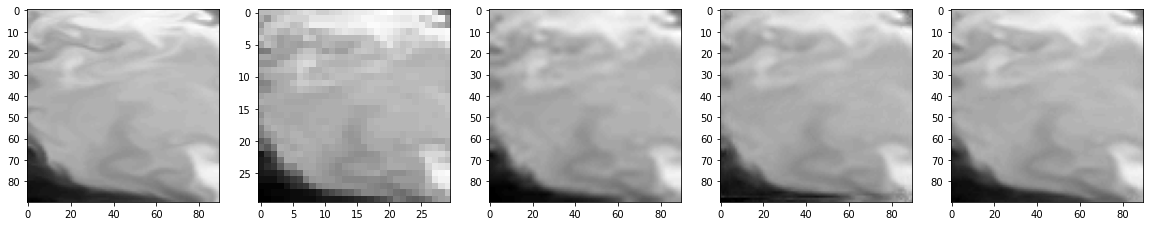

VSRnet PSNR:  46.6904296875
SRCNN PSNR:  45.282318115234375
Bicubic PSNR:  39.89855770201048


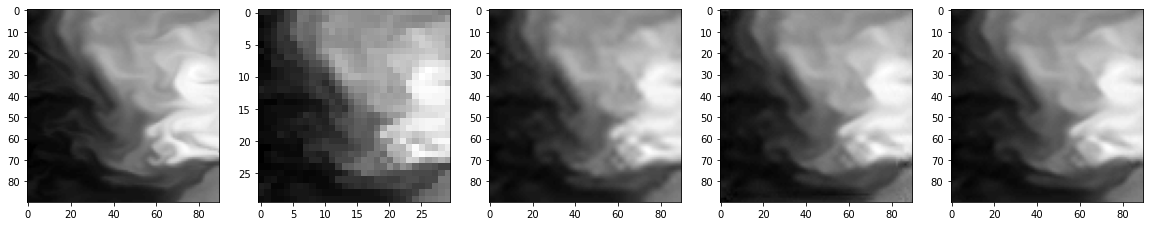

VSRnet PSNR:  38.84467315673828
SRCNN PSNR:  34.74788284301758
Bicubic PSNR:  33.92733367076477


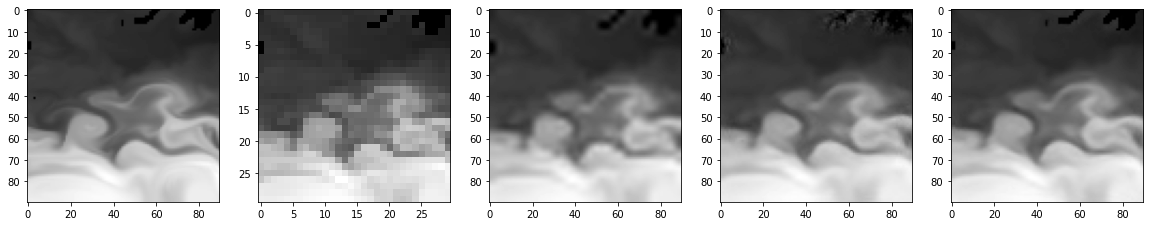

VSRnet PSNR:  51.563987731933594
SRCNN PSNR:  50.313507080078125
Bicubic PSNR:  45.114609826816746


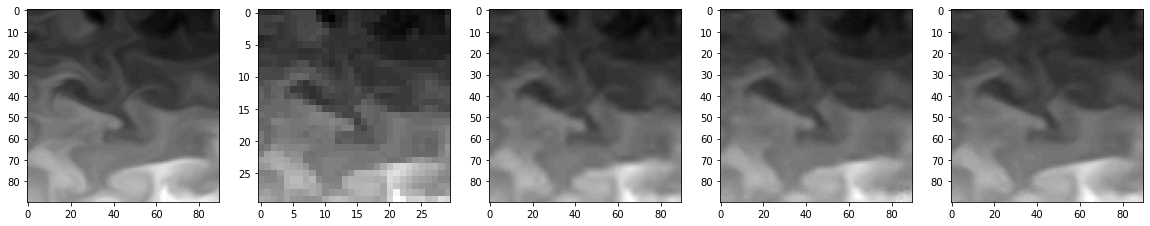

VSRnet PSNR:  49.20723342895508
SRCNN PSNR:  48.59761047363281
Bicubic PSNR:  43.00158904338144


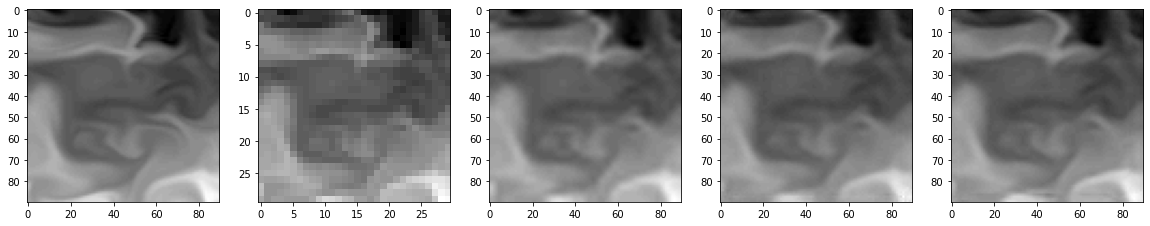

VSRnet PSNR:  41.127906799316406
SRCNN PSNR:  40.69135284423828
Bicubic PSNR:  43.59931965836503


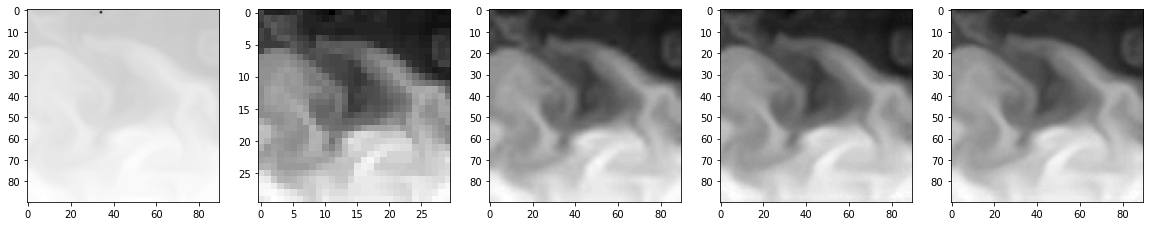

VSRnet Average PSNR:  46.240196228027344
SRCNN Average PSNR:  44.93666076660156
Bicubic Average PSNR:  41.3988494629917


In [19]:
# TEST

srcnn.eval()
vsrnet.eval()
bicubic_test_psnr = AverageMeter()
vsrnet_test_psnr = AverageMeter()
srcnn_test_psnr = AverageMeter()


count = 0
for data in test_dataloader:
    
    # get data, transpose to device
    sequences_imgs, target_imgs = data
    sequences_imgs = sequences_imgs.to('cpu')
    target_imgs = target_imgs.to('cpu')
    
    #print(sequence_imgs.shape)
    #print(sequence_imgs[:, [SEQUENCE_SIZE//2], :, :].shape)
    
    # predict (no_grad) is important, not use to update model
    # cut compute graphe to reduce needed memory of device and 
    # accelerate the computation
    with torch.no_grad():
        vsrnet_outputs = vsrnet(sequences_imgs).clamp(0.0, 1.0)
        srcnn_outputs = srcnn(sequences_imgs[:, [SEQUENCE_SIZE//2], :, :]).clamp(0.0, 1.0)
        
    # calculate psnr
    vsrnet_psnr = computePSNR(vsrnet_outputs, target_imgs)
    srcnn_psnr = computePSNR(srcnn_outputs, target_imgs)
    
    vsrnet_test_psnr.update(vsrnet_psnr, len(target_imgs))
    srcnn_test_psnr.update(srcnn_psnr, len(target_imgs))
    
    _,_, h,w = target_imgs.shape
    
    vsrnet_outputs = torch.reshape(vsrnet_outputs, (1,h,w))
    vsrnet_output_imgs = transforms.ToPILImage()(vsrnet_outputs)
    
    #print(srcnn_outputs.shape)
    
    srcnn_outputs = torch.reshape(srcnn_outputs, (1,h,w))
    srcnn_output_imgs = transforms.ToPILImage()(srcnn_outputs)
    
    target_imgs = torch.reshape(target_imgs, (1,h,w))
    target_imgs = transforms.ToPILImage()(target_imgs)
    
    lr_imgs = np.array(target_imgs)
    lr_imgs = cv2.resize(lr_imgs, (h//SCALE, w//SCALE), interpolation=cv2.INTER_NEAREST)
    
    bi_imgs = cv2.resize(lr_imgs, (h, w), interpolation=cv2.INTER_CUBIC)
    
    bicubic_psnr = cal_psnr(bi_imgs, np.array(target_imgs))
    bicubic_test_psnr.update(bicubic_psnr, 1)
    
    
    if count % 50 == 0:
        print("VSRnet PSNR: ", vsrnet_psnr.item())
        print("SRCNN PSNR: ", srcnn_psnr.item())
        print("Bicubic PSNR: ", bicubic_psnr)
        fig,axes = plt.subplots(1, 5, figsize=(20, 100)) # 1 lows, 2 cols
        axes[0].imshow(target_imgs, cmap='gray')
        axes[1].imshow(lr_imgs, cmap='gray')
        axes[2].imshow(bi_imgs, cmap='gray')
        axes[3].imshow(srcnn_output_imgs, cmap='gray')
        axes[4].imshow(vsrnet_output_imgs, cmap='gray')
        plt.show()
    count += 1

    
print("VSRnet Average PSNR: ", vsrnet_test_psnr.avg.item())
print("SRCNN Average PSNR: ", srcnn_test_psnr.avg.item())
print("Bicubic Average PSNR: ", bicubic_test_psnr.avg)